In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [ ]:
dataset =datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database",transform=None)

class_names=dataset.classes
print(class_names)
print(len(class_names))


['Asthma Plant.zip', 'Avaram.zip', 'Balloon vine.zip', 'Bellyache bush (Green).zip', 'Benghal dayflower.zip', 'Big Caltrops.zip', 'Black-Honey Shrub.zip', 'Bristly Wild Grape.zip', 'Butterfly Pea.zip', 'Cape Gooseberry.zip', 'Common Wireweed.zip', 'Country Mallow.zip', 'Crown flower.zip', 'Green Chireta.zip', 'Holy Basil.zip', 'Indian CopperLeaf.zip', 'Indian Jujube.zip', 'Indian Sarsaparilla.zip', 'Indian Stinging Nettle.zip', 'Indian Thornapple.zip', 'Indian wormwood.zip', 'Ivy Gourd.zip', 'Kokilaksha.zip', 'Land Caltrops (Bindii).zip', 'Madagascar Periwinkle.zip', 'Madras Pea Pumpkin.zip', 'Malabar Catmint.zip', 'Mexican Mint.zip', 'Mexican Prickly Poppy.zip', 'Mountain Knotgrass.zip', 'Nalta Jute.zip', 'Night blooming Cereus.zip', 'Panicled Foldwing.zip', 'Prickly Chaff Flower.zip', 'Punarnava.zip', 'Purple Fruited Pea Eggplant.zip', 'Purple Tephrosia.zip', 'Rosary Pea.zip', 'Shaggy button weed.zip', 'Small Water Clover.zip', 'Spiderwisp.zip', 'Square Stalked Vine.zip', 'Stinking P

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


In [ ]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(30),
        transforms.RandomResizedCrop((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", transform=data_transforms['train']),
    'validation': datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", transform=data_transforms['validation']),
    'test': datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", transform=data_transforms['test']),
}

# Split the dataset
train_size = int(0.75 * len(image_datasets['train']))
val_size = int(0.15 * len(image_datasets['train']))
test_size = len(image_datasets['train']) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_datasets['train'], [train_size, val_size, test_size])
batch_size = 64  # Increase the batch size
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
}


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = models.resnet152(pretrained=True).to(device)
# Modify the model architecture here as needed

for param in model.parameters():
    param.requires_grad = True


In [ ]:

model.fc = nn.Sequential(
                nn.Linear(2048, 128),
                nn.LayerNorm(128),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.2),
#                 nn.Linear(512, 256),
#                 nn.LayerNorm(256),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(p=0.3),
                nn.Linear(128, 50)
                ).to(device)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),  lr=0.01)
from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=5, dataloaders=None, image_datasets=None, device=None):
    scaler = GradScaler()  # For mixed precision training
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device, non_blocking=True)  # Asynchronous data transfer
                labels = labels.to(device, non_blocking=True)

                with autocast():  # Mixed precision training
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    if scheduler:
                        scheduler.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')

    return model


In [ ]:
# Train the model
model_trained = train_model(model, criterion, optimizer, num_epochs=20, dataloaders=dataloaders, image_datasets=image_datasets, device=device)
model_trained1 = train_model(model_trained, criterion, optimizer, num_epochs=10, dataloaders=dataloaders, image_datasets=image_datasets, device=device)
model_trained2 = train_model(model_trained1, criterion, optimizer, num_epochs=20, dataloaders=dataloaders, image_datasets=image_datasets, device=device)


Epoch 1/20
----------


100%|██████████| 60/60 [01:18<00:00,  1.30s/it]


train loss: 3.7565, acc: 0.0887


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 3.1648, acc: 0.2505
Epoch 2/20
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 2.1658, acc: 0.4189


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


validation loss: 1.1304, acc: 0.6876
Epoch 3/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


train loss: 1.2895, acc: 0.6193


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 2.3944, acc: 0.3310
Epoch 4/20
----------


100%|██████████| 60/60 [01:25<00:00,  1.42s/it]


train loss: 1.7811, acc: 0.5308


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 1.1743, acc: 0.6410
Epoch 5/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


train loss: 1.4705, acc: 0.5851


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.8955, acc: 0.7376
Epoch 6/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]


train loss: 1.4090, acc: 0.6044


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


validation loss: 0.6902, acc: 0.8115
Epoch 7/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


train loss: 1.2296, acc: 0.6479


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


validation loss: 0.8408, acc: 0.7583
Epoch 8/20
----------


100%|██████████| 60/60 [01:16<00:00,  1.27s/it]


train loss: 1.1498, acc: 0.6796


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.8222, acc: 0.7501
Epoch 9/20
----------


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


train loss: 1.2951, acc: 0.6481


100%|██████████| 60/60 [01:09<00:00,  1.15s/it]


validation loss: 0.9259, acc: 0.7066
Epoch 10/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


train loss: 1.2452, acc: 0.6624


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.8393, acc: 0.7257
Epoch 11/20
----------


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


train loss: 1.0991, acc: 0.6773


100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


validation loss: 1.0285, acc: 0.6365
Epoch 12/20
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.9793, acc: 0.7220


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.6062, acc: 0.8067
Epoch 13/20
----------


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


train loss: 1.0483, acc: 0.7082


100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


validation loss: 0.5464, acc: 0.8356
Epoch 14/20
----------


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


train loss: 0.9045, acc: 0.7397


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


validation loss: 0.5018, acc: 0.8589
Epoch 15/20
----------


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


train loss: 1.1971, acc: 0.6775


100%|██████████| 60/60 [01:07<00:00,  1.12s/it]


validation loss: 0.5325, acc: 0.8517
Epoch 16/20
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.9798, acc: 0.7217


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.4937, acc: 0.8618
Epoch 17/20
----------


100%|██████████| 60/60 [01:19<00:00,  1.32s/it]


train loss: 0.9948, acc: 0.7135


100%|██████████| 60/60 [01:10<00:00,  1.17s/it]


validation loss: 0.5587, acc: 0.8223
Epoch 18/20
----------


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


train loss: 0.9342, acc: 0.7318


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


validation loss: 0.3754, acc: 0.9015
Epoch 19/20
----------


100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


train loss: 0.9563, acc: 0.7297


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


validation loss: 0.3808, acc: 0.8957
Epoch 20/20
----------


100%|██████████| 60/60 [01:26<00:00,  1.45s/it]


train loss: 0.9140, acc: 0.7429


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


validation loss: 0.4367, acc: 0.8679
Epoch 1/10
----------


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


train loss: 0.8163, acc: 0.7588


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.3411, acc: 0.9028
Epoch 2/10
----------


100%|██████████| 60/60 [01:21<00:00,  1.37s/it]


train loss: 0.6524, acc: 0.8088


100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


validation loss: 0.4829, acc: 0.8486
Epoch 3/10
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 1.1889, acc: 0.6900


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


validation loss: 0.5319, acc: 0.8584
Epoch 4/10
----------


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


train loss: 0.8853, acc: 0.7408


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.6004, acc: 0.8194
Epoch 5/10
----------


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


train loss: 1.0223, acc: 0.7225


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


validation loss: 0.4569, acc: 0.8753
Epoch 6/10
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.9668, acc: 0.7257


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.3827, acc: 0.8994
Epoch 7/10
----------


100%|██████████| 60/60 [01:20<00:00,  1.33s/it]


train loss: 0.8119, acc: 0.7601


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


validation loss: 0.4967, acc: 0.8425
Epoch 8/10
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.9716, acc: 0.7236


100%|██████████| 60/60 [01:08<00:00,  1.13s/it]


validation loss: 0.4490, acc: 0.8679
Epoch 9/10
----------


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


train loss: 0.8735, acc: 0.7572


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


validation loss: 0.3870, acc: 0.8872
Epoch 10/10
----------


100%|██████████| 60/60 [01:16<00:00,  1.27s/it]


train loss: 0.6048, acc: 0.8205


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


validation loss: 0.3815, acc: 0.8803
Epoch 1/20
----------


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


train loss: 0.8362, acc: 0.7532


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.3801, acc: 0.8888
Epoch 2/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]


train loss: 0.6005, acc: 0.8189


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


validation loss: 0.3258, acc: 0.9050
Epoch 3/20
----------


100%|██████████| 60/60 [01:16<00:00,  1.27s/it]


train loss: 0.7967, acc: 0.7620


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.5807, acc: 0.8141
Epoch 4/20
----------


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


train loss: 0.9772, acc: 0.7254


100%|██████████| 60/60 [01:08<00:00,  1.13s/it]


validation loss: 0.3280, acc: 0.9102
Epoch 5/20
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.9147, acc: 0.7323


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.5238, acc: 0.8321
Epoch 6/20
----------


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


train loss: 0.9403, acc: 0.7363


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


validation loss: 0.3579, acc: 0.8978
Epoch 7/20
----------


100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


train loss: 0.8464, acc: 0.7564


100%|██████████| 60/60 [01:19<00:00,  1.32s/it]


validation loss: 0.4127, acc: 0.8697
Epoch 8/20
----------


100%|██████████| 60/60 [01:22<00:00,  1.37s/it]


train loss: 0.9586, acc: 0.7223


100%|██████████| 60/60 [01:14<00:00,  1.25s/it]


validation loss: 0.3754, acc: 0.8928
Epoch 9/20
----------


100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


train loss: 0.8649, acc: 0.7495


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


validation loss: 0.3798, acc: 0.8859
Epoch 10/20
----------


100%|██████████| 60/60 [01:20<00:00,  1.33s/it]


train loss: 0.6294, acc: 0.8065


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.3781, acc: 0.8864
Epoch 11/20
----------


100%|██████████| 60/60 [01:20<00:00,  1.33s/it]


train loss: 0.9163, acc: 0.7337


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.4905, acc: 0.8509
Epoch 12/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


train loss: 0.7990, acc: 0.7636


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.3616, acc: 0.8930
Epoch 13/20
----------


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


train loss: 0.8194, acc: 0.7670


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


validation loss: 0.4479, acc: 0.8663
Epoch 14/20
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.9577, acc: 0.7265


100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


validation loss: 0.3309, acc: 0.8997
Epoch 15/20
----------


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


train loss: 0.9869, acc: 0.7183


100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


validation loss: 0.5210, acc: 0.8467
Epoch 16/20
----------


100%|██████████| 60/60 [01:17<00:00,  1.29s/it]


train loss: 1.0019, acc: 0.7111


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.3232, acc: 0.9132
Epoch 17/20
----------


100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


train loss: 0.9285, acc: 0.7305


100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


validation loss: 0.4478, acc: 0.8697
Epoch 18/20
----------


100%|██████████| 60/60 [01:18<00:00,  1.30s/it]


train loss: 1.0526, acc: 0.6979


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


validation loss: 0.4475, acc: 0.8774
Epoch 19/20
----------


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


train loss: 0.9011, acc: 0.7363


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.4154, acc: 0.8745
Epoch 20/20
----------


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


train loss: 0.8929, acc: 0.7432


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]

validation loss: 0.3473, acc: 0.9076


In [ ]:
# model_trained1 = train_model(model_trained, criterion, optimizer, num_epochs=10)

In [ ]:
# model_trained2 = train_model(model_trained1, criterion, optimizer, num_epochs=20)

In [ ]:
torch.save(model_trained2.state_dict(), '/content/drive/MyDrive/ALL/MapcoLeafDetection/plant_model_classification2.h5')
torch.save(model_trained1.state_dict(), '/content/drive/MyDrive/ALL/MapcoLeafDetection/plant_model_classification1.h5')
torch.save(model_trained.state_dict(), '/content/drive/MyDrive/ALL/MapcoLeafDetection/plant_model_classification.h5')

In [ ]:
model_trained3 = train_model(model_trained2, criterion, optimizer, num_epochs=30, dataloaders=dataloaders, image_datasets=image_datasets, device=device)

Epoch 1/30
----------


  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 60/60 [01:17<00:00,  1.30s/it]


train loss: 0.8585, acc: 0.7503


100%|██████████| 60/60 [01:06<00:00,  1.12s/it]


validation loss: 0.2979, acc: 0.9145
Epoch 2/30
----------


100%|██████████| 60/60 [01:15<00:00,  1.26s/it]


train loss: 0.5806, acc: 0.8231


100%|██████████| 60/60 [01:11<00:00,  1.19s/it]


validation loss: 0.2699, acc: 0.9208
Epoch 3/30
----------


100%|██████████| 60/60 [01:19<00:00,  1.32s/it]


train loss: 0.7260, acc: 0.7850


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.2765, acc: 0.9214
Epoch 4/30
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.5761, acc: 0.8242


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


validation loss: 0.4228, acc: 0.8655
Epoch 5/30
----------


100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


train loss: 0.9201, acc: 0.7389


100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


validation loss: 0.4244, acc: 0.8745
Epoch 6/30
----------


100%|██████████| 60/60 [01:18<00:00,  1.30s/it]


train loss: 0.8962, acc: 0.7337


100%|██████████| 60/60 [01:10<00:00,  1.17s/it]


validation loss: 0.3857, acc: 0.8790
Epoch 7/30
----------


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


train loss: 0.8547, acc: 0.7535


100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


validation loss: 0.2923, acc: 0.9214
Epoch 8/30
----------


100%|██████████| 60/60 [01:18<00:00,  1.32s/it]


train loss: 0.7495, acc: 0.7702


100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


validation loss: 0.3627, acc: 0.8864
Epoch 9/30
----------


 67%|██████▋   | 40/60 [00:54<00:18,  1.10it/s]

In [ ]:
torch.save(model_trained3.state_dict(), '/content/drive/MyDrive/ALL/MapcoLeafDetection/plant_model_classification3.h5')

In [ ]:
model = models.resnet152(pretrained=False).to(device)
model.fc = nn.Sequential(
                nn.Linear(2048, 128),
                nn.LayerNorm(128),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.2),
#                 nn.Linear(512, 256),
#                 nn.LayerNorm(256),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(p=0.3),
                nn.Linear(128, 50)
                ).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/ALL/MapcoLeafDetection/plant_model_classification2.h5'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
y_true = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        y_true.append(labels.tolist())

In [ ]:
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 23, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 45, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 30, 2, 2, 2, 2, 2, 2, 36, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 30, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 20, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 20, 34, 36, 30, 20, 36, 2, 36, 36, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 18, 3, 3, 3, 3, 3, 3,

In [ ]:
from itertools import chain
y_true_flat = list(chain.from_iterable(y_true))
print(y_true_flat)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_flat, y_pred)

In [ ]:
accuracy

0.9057453005030447

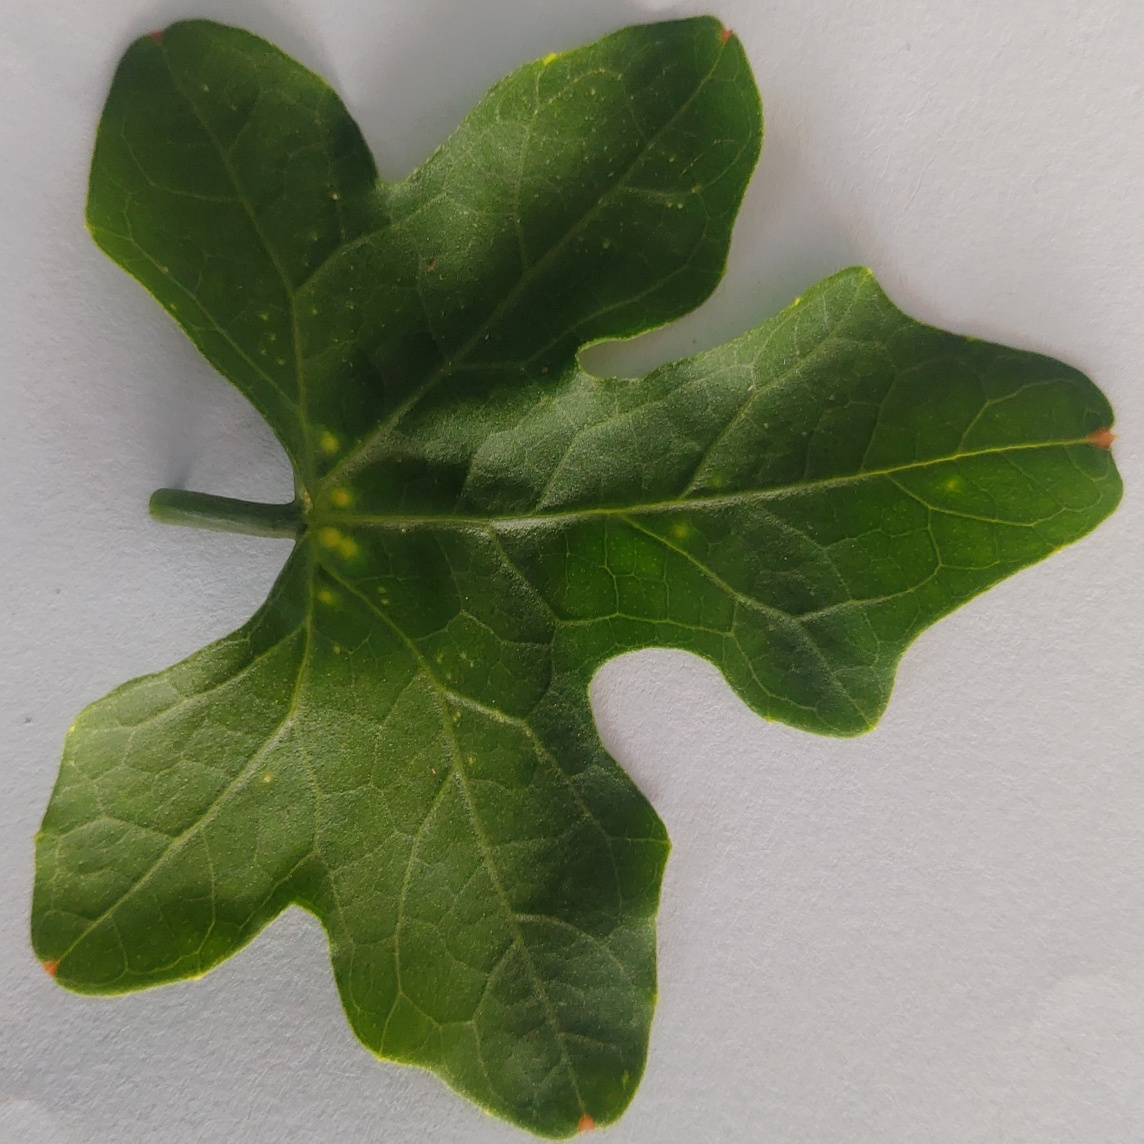

In [ ]:
image = Image.open('/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database/Ivy Gourd.zip/022_10.jpg').convert('RGB')
image

In [ ]:
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with mean and standard deviation
        std=[0.229, 0.224, 0.225]
    )
])
normalized_image = transform1(image).unsqueeze(0)
print(normalized_image.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
norm_image = normalized_image.cuda()
model.eval()
outputs = model(norm_image)
_, predicted = torch.max(outputs.data, 1)
print('Predicted class:', predicted.item())

Predicted class: 21


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# import random
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import random_split, DataLoader
# from torchvision import datasets, transforms, models
# from torchvision.datasets import ImageFolder
# from torchvision.utils import make_grid
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, accuracy_score
# from PIL import Image
# from itertools import chain

# # Mounting drive
# dataset = datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", transform=None)

# class_names = dataset.classes
# print(class_names)
# print(len(class_names))

# # Define the path where you want to save the augmented images
# augmented_images_save_path = "/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Augmented"
# os.makedirs(augmented_images_save_path, exist_ok=True)

# # for calculating the accuracy
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# # base class for the model
# class ImageClassificationBase(nn.Module):

#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)                   # Generate prediction
#         loss = F.cross_entropy(out, labels)  # Calculate loss
#         acc = accuracy(out, labels)          # Calculate accuracy
#         return {"val_loss": loss.detach(), "val_accuracy": acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x["val_loss"] for x in outputs]
#         batch_accuracy = [x["val_accuracy"] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
#         epoch_accuracy = torch.stack(batch_accuracy).mean()
#         return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomAffine(30),
#         transforms.RandomResizedCrop((224, 224)),
#         transforms.ToTensor(),
#         normalize
#     ]),
#     'validation': transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         normalize
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         normalize
#     ])
# }

# image_datasets = {
#     'train': datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", transform=data_transforms['train']),
#     'validation': datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", transform=data_transforms['validation']),
#     'test': datasets.ImageFolder(root="/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", transform=data_transforms['test']),
# }

# train_size = int(0.75 * len(image_datasets['train']))
# val_size = int(0.15 * len(image_datasets['train']))
# test_size = len(image_datasets['train']) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(image_datasets['train'], [train_size, val_size, test_size])

# dataloaders = {
#     'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True),
#     'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=16, shuffle=False),
#     'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=16, shuffle=False)
# }

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

# model = models.resnet152(pretrained=True).to(device)

# for param in model.parameters():
#     param.requires_grad = True

# model.fc = nn.Sequential(
#     nn.Linear(2048, 128),
#     nn.LayerNorm(128),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.2),
#     nn.Linear(128, len(class_names))
# ).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# def train_model(model, criterion, optimizer, num_epochs=5):
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#         print('-' * 10)

#         for phase in ['train', 'validation']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 if phase == 'train':
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                 _, preds = torch.max(outputs, 1)
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(image_datasets[phase])
#             epoch_acc = running_corrects.double() / len(image_datasets[phase])

#             print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
#     return model

# model_trained = train_model(model, criterion, optimizer, num_epochs=20)
# model_trained1 = train_model(model_trained, criterion, optimizer, num_epochs=10)
# model_trained2 = train_model(model_trained1, criterion, optimizer, num_epochs=20)

# # Save the trained model
# model_save_path = "/content/drive/MyDrive/ALL/MapcoLeafDetection/plant_model_classification.h5"
# torch.save(model_trained2.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

# # Evaluate the model
# model = models.resnet152(pretrained=False).to(device)
# model.fc = nn.Sequential(
#     nn.Linear(2048, 128),
#     nn.LayerNorm(128),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.2),
#     nn.Linear(128, len(class_names))
# ).to(device)
# model.load_state_dict(torch.load(model_save_path))

# model.eval()
# y_pred = []
# with torch.no_grad():
#     for inputs, labels in dataloaders['test']:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         y_pred.extend(preds.tolist())

# y_true = []
# with torch.no_grad():
#     for inputs, labels in dataloaders['test']:
#         y_true.append(labels.tolist())

# y_true_flat = list(chain.from_iterable(y_true))
# accuracy = accuracy_score(y_true_flat, y_pred)
# print(f"Test Accuracy: {accuracy}")

# # Function to save augmented images
# def save_augmented_images(datagen, samples, num_images, save_path, prefix):
#     for i in range(num_images):
#         augmented_image = datagen(samples)
#         file_path = os.path.join(save_path, f"{prefix}_aug_{i+1}.jpg")
#         augmented_image_pil = transforms.ToPILImage()(augmented_image.squeeze())
#         augmented_image_pil.save(file_path)
#         print(f"Image saved to {file_path}")

# # Example of saving augmented images with different augmentations
# image_files = glob.glob(os.path.join("/content/drive/MyDrive/ALL/MapcoLeafDetection/dataset/MepcoTropicLeaf-V1/Database", '*.jpg'))
# random_image_path = random.choice(image_files)
# image = Image.open(random_image_path).convert('RGB')
# samples = transform1(image).unsqueeze(0)

# # Width shift augmentation
# datagen = transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))
# save_augmented_images(datagen, samples, 3, augmented_images_save_path, "width_shift")

# # Horizontal and vertical flip augmentation
# datagen = transforms.RandomHorizontalFlip(p=1.0)
# save_augmented_images(datagen, samples, 3, augmented_images_save_path, "horizontal_flip")

# datagen = transforms.RandomVerticalFlip(p=1.0)
# save_augmented_images(datagen, samples, 3, augmented_images_save_path, "vertical_flip")

# # Rotation augmentation
# datagen = transforms.RandomRotation(degrees=20)
# save_augmented_images(datagen, samples, 3, augmented_images_save_path, "rotation")

# # Brightness augmentation
# datagen = transforms.ColorJitter(brightness=(0.5, 2.0))
# save_augmented_images(datagen, samples, 3, augmented_images_save_path, "brightness")
